### Image files directory tree
<pre>.
└── Data
    └── CATS_DOGS
        ├── test
        │   ├── CAT
        │   │   ├── 9374.jpg
        │   │   ├── 9375.jpg
        │   │   └── ... (3,126 files)
        │   └── DOG
        │       ├── 9374.jpg
        │       ├── 9375.jpg
        │       └── ... (3,125 files)       
        │           
        └── train
            ├── CAT
            │   ├── 0.jpg
            │   ├── 1.jpg
            │   └── ... (9,371 files)
            └── DOG
                ├── 0.jpg
                ├── 1.jpg
                └── ... (9,372 files)</pre>

## Perform standard imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models # add models to the list
from torchvision.utils import make_grid

In [3]:
import os

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

# ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

## Define transforms
We looked at a variety of transforms available for data augmentation (rotate, flip, etc.) and normalization.<br>
Here we'll combine the ones we want, including the <a href='https://discuss.pytorch.org/t/normalization-in-the-mnist-example/457/22'>recommended normalization parameters</a> for mean and std per channel.

In [4]:
train_transform = transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])


In [5]:
test_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

## Prepare train and test sets, loaders
We're going to take advantage of a built-in torchvision dataset tool called <a href='https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder'><tt><strong>ImageFolder</strong></tt></a>.

In [6]:
root = '../Data/CATS_DOGS'

train_data = datasets.ImageFolder(os.path.join(root, 'train'), transform=train_transform)
test_data = datasets.ImageFolder(os.path.join(root, 'test'), transform=test_transform)

In [7]:
train_data

Dataset ImageFolder
    Number of datapoints: 18743
    Root Location: ../Data/CATS_DOGS\train
    Transforms (if any): Compose(
                             RandomRotation(degrees=(-10, 10), resample=False, expand=False)
                             RandomHorizontalFlip(p=0.5)
                             Resize(size=224, interpolation=PIL.Image.BILINEAR)
                             CenterCrop(size=(224, 224))
                             ToTensor()
                             Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                         )
    Target Transforms (if any): None

In [8]:
test_data

Dataset ImageFolder
    Number of datapoints: 6251
    Root Location: ../Data/CATS_DOGS\test
    Transforms (if any): Compose(
                             Resize(size=224, interpolation=PIL.Image.BILINEAR)
                             CenterCrop(size=(224, 224))
                             ToTensor()
                             Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                         )
    Target Transforms (if any): None

In [9]:
torch.manual_seed(42)
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=True)

In [10]:
for image,label in train_loader:
    break

In [11]:
image.shape

torch.Size([10, 3, 224, 224])

In [12]:
image[0].shape

torch.Size([3, 224, 224])

In [13]:
image[0][0].shape

torch.Size([224, 224])

In [14]:
label.shape

torch.Size([10])

In [15]:
class_names = train_data.classes

print(class_names)
print(f'Training images available: {len(train_data)}')
print(f'Testing images available:  {len(test_data)}')

['CAT', 'DOG']
Training images available: 18743
Testing images available:  6251


## Display a batch of images
To verify that the training loader selects cat and dog images at random, let's show a batch of loaded images.<br>
Recall that imshow clips pixel values <0, so the resulting display lacks contrast. We'll apply a quick inverse transform to the input tensor so that images show their "true" colors.

Label: [ 1  0  0  1  1  0  1  1  0  0]
Class: DOG CAT CAT DOG DOG CAT DOG DOG CAT CAT


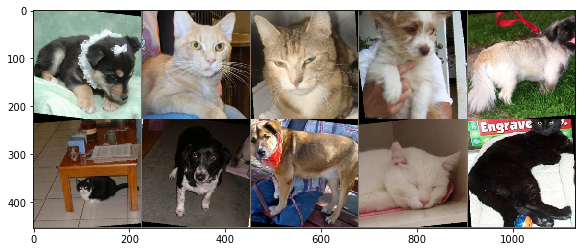

In [16]:
np.set_printoptions(formatter=dict(int=lambda x: f'{x:2}')) # to widen the printed array

# Grab the first batch of 10 images
for images,labels in train_loader: 
    break

# Print the labels
print('Label:', labels.numpy())
print('Class:', *np.array([class_names[i] for i in labels]))

im = make_grid(images, nrow=5)  # the default nrow is 8

# Inverse normalize the images
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)

# Print the images
plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)));

## Define the model
We'll start by using a model similar to the one we applied to the CIFAR-10 dataset, except that here we have a binary classification (2 output channels, not 10). Also, we'll add another set of convolution/pooling layers.

In [17]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        
        self.fc1 = nn.Linear(54*54*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 54*54*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        
        return F.log_softmax(X, dim=1)

<div class="alert alert-info"><strong>Why <tt>(54x54x16)</tt>?</strong><br>
With 224 pixels per side, the kernels and pooling layers result in $\;(((224-2)/2)-2)/2 = 54.5\;$ which rounds down to 54 pixels per side.</div>

### Instantiate the model, define loss and optimization functions
We're going to call our model "CNNmodel" to differentiate it from pretrained model "AlexNetmodel","vgg11" and "resnet18" we'll use later.

In [18]:
torch.manual_seed(101)
CNNmodel = ConvolutionalNetwork()

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(CNNmodel.parameters(), lr=0.001)

CNNmodel

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=46656, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)

### Looking at the trainable parameters

In [19]:
for params in CNNmodel.parameters():
    print(params)

Parameter containing:
tensor([[[[-0.1162, -0.0191, -0.1575],
          [ 0.1490, -0.0811, -0.1853],
          [ 0.1576, -0.0614, -0.0266]],

         [[ 0.0894, -0.0086, -0.1649],
          [ 0.0321,  0.0970,  0.1020],
          [-0.1369,  0.0828, -0.0403]],

         [[ 0.0479, -0.0507,  0.1471],
          [-0.0483, -0.1363, -0.0512],
          [ 0.0248,  0.0105, -0.1486]]],


        [[[-0.1543, -0.1294,  0.1035],
          [-0.0067,  0.1162, -0.0417],
          [-0.0664,  0.0032, -0.0595]],

         [[ 0.0470,  0.0267,  0.0836],
          [-0.0967, -0.0237,  0.1238],
          [ 0.0285,  0.0799, -0.0339]],

         [[ 0.1403, -0.0791,  0.0499],
          [ 0.1400, -0.0241,  0.0175],
          [-0.0871, -0.0807, -0.0514]]],


        [[[-0.1270, -0.1649, -0.1487],
          [ 0.1756,  0.0932, -0.0899],
          [ 0.1029,  0.0184,  0.1261]],

         [[-0.1232, -0.1280,  0.0039],
          [-0.0195, -0.1913,  0.1680],
          [-0.0289,  0.1808, -0.0495]],

         [[-0.0133,  0

In [20]:
for params in CNNmodel.parameters():
    print(params.size())

torch.Size([6, 3, 3, 3])
torch.Size([6])
torch.Size([16, 6, 3, 3])
torch.Size([16])
torch.Size([120, 46656])
torch.Size([120])
torch.Size([84, 120])
torch.Size([84])
torch.Size([2, 84])
torch.Size([2])


In [21]:
for params in CNNmodel.parameters():
    print(params.numel())

162
6
864
16
5598720
120
10080
84
168
2


In [22]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:<8}')
    print(f'________\n{sum(params):<8}')

In [23]:
count_parameters(CNNmodel)

162     
6       
864     
16      
5598720 
120     
10080   
84      
168     
2       
________
5610222 


## Train the model
In the interests of time, we'll limit the number of training batches to 800, and the number of testing batches to 300. We'll train the model on 8000 of 18743 available images, and test it on 3000 out of 6251 images.

In [24]:
import time
start_time = time.time()

epochs = 2

max_trn_batch = 800
max_tst_batch = 300

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        
        # Limit the number of batches
        if b == max_trn_batch:
            break
        b+=1
        
        # Apply the model
        y_pred = CNNmodel(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        if b%50 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/8000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')

    train_losses.append(loss)
    train_correct.append(trn_corr)

    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            # Limit the number of batches
            if b == max_tst_batch:
                break

            # Apply the model
            y_val = CNNmodel(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:  0  batch:   50 [   500/8000]  loss: 0.60630459  accuracy:  53.400%
epoch:  0  batch:  100 [  1000/8000]  loss: 0.65811527  accuracy:  53.700%
epoch:  0  batch:  150 [  1500/8000]  loss: 0.74930513  accuracy:  55.733%
epoch:  0  batch:  200 [  2000/8000]  loss: 0.74302483  accuracy:  56.700%
epoch:  0  batch:  250 [  2500/8000]  loss: 0.68582517  accuracy:  57.640%
epoch:  0  batch:  300 [  3000/8000]  loss: 0.76324832  accuracy:  59.067%
epoch:  0  batch:  350 [  3500/8000]  loss: 0.75810218  accuracy:  59.343%
epoch:  0  batch:  400 [  4000/8000]  loss: 0.65925854  accuracy:  59.300%
epoch:  0  batch:  450 [  4500/8000]  loss: 0.63496494  accuracy:  59.578%
epoch:  0  batch:  500 [  5000/8000]  loss: 0.49787027  accuracy:  60.100%
epoch:  0  batch:  550 [  5500/8000]  loss: 0.74131328  accuracy:  60.309%
epoch:  0  batch:  600 [  6000/8000]  loss: 0.58557063  accuracy:  60.733%
epoch:  0  batch:  650 [  6500/8000]  loss: 0.68341410  accuracy:  61.062%
epoch:  0  batch:  700 [ 

In [25]:

# epochs = 3

# for i in range(epochs):
#     for X_train, y_train in train_loader:

#         # Apply the model
#         y_pred = model(X_train)
#         loss = criterion(y_pred, y_train)

#         # Update parameters
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#     # OPTIONAL print statement
#     print(f'{i+1} of {epochs} epochs completed')

## Save the trained model

In [26]:
torch.save(CNNmodel.state_dict(), 'CustomImageCNNModel.pt')

## Load the saved  model

In [27]:
# Instantiate the model and load saved parameters
model2 = ConvolutionalNetwork()
model2.load_state_dict(torch.load('CustomImageCNNModel.pt'))
model2.eval()

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=46656, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)

## Evaluate model performance

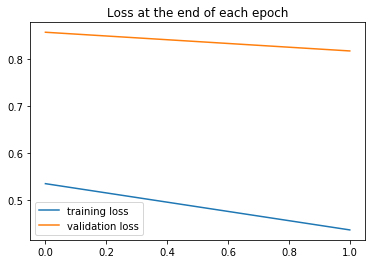

In [28]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

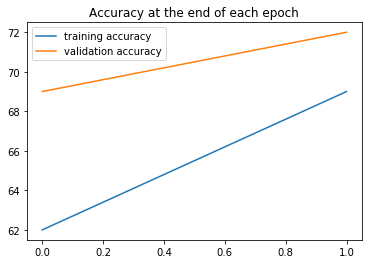

In [29]:
plt.plot([t/80 for t in train_correct], label='training accuracy')
plt.plot([t/30 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [31]:
print(test_correct)
print(f'Test accuracy: {test_correct[-1].item()*100/3000:.3f}%')

[tensor(2086), tensor(2179)]
Test accuracy: 72.633%


## Download a pretrained model
Torchvision has a number of proven models available through <a href='https://pytorch.org/docs/stable/torchvision/models.html#classification'><tt><strong>torchvision.models</strong></tt></a>:
<ul>
<li><a href="https://arxiv.org/abs/1404.5997">AlexNet</a></li>
<li><a href="https://arxiv.org/abs/1409.1556">VGG</a></li>
<li><a href="https://arxiv.org/abs/1512.03385">ResNet</a></li>
<li><a href="https://arxiv.org/abs/1602.07360">SqueezeNet</a></li>
<li><a href="https://arxiv.org/abs/1608.06993">DenseNet</a></li>
<li><a href="https://arxiv.org/abs/1512.00567">Inception</a></li>
<li><a href="https://arxiv.org/abs/1409.4842">GoogLeNet</a></li>
<li><a href="https://arxiv.org/abs/1807.11164">ShuffleNet</a></li>
<li><a href="https://arxiv.org/abs/1801.04381">MobileNet</a></li>
<li><a href="https://arxiv.org/abs/1611.05431">ResNeXt</a></li>
</ul>
These have all been trained on the <a href='http://www.image-net.org/'>ImageNet</a> database of images. Our only task is to reduce the output of the fully connected layers from (typically) 1000 categories to just 2.

To access the models, you can construct a model with random weights by calling its constructor:<br>
<pre>resnet18 = models.resnet18()</pre>
You can also obtain a pre-trained model by passing pretrained=True:<br>
<pre>resnet18 = models.resnet18(pretrained=True)</pre>
All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].

Feel free to investigate the different models available. Each one will be downloaded to a cache directory the first time they're accessed - from then on they'll be available locally.

For its simplicity and effectiveness, we'll use AlexNet:

In [40]:
inception = models.inception_v3(pretrained=True)
inception

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

In [42]:
densenet121 = models.densenet121(pretrained =True)
densenet121

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

## Load the pretrained resnet18 models

In [43]:
resnet18 = models.resnet18(pretrained=True)
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

## check for parameters in resnet18 model

In [44]:
for params in resnet18.parameters():
    print(params.numel())

9408
64
64
36864
64
64
36864
64
64
36864
64
64
36864
64
64
73728
128
128
147456
128
128
8192
128
128
147456
128
128
147456
128
128
294912
256
256
589824
256
256
32768
256
256
589824
256
256
589824
256
256
1179648
512
512
2359296
512
512
131072
512
512
2359296
512
512
2359296
512
512
512000
1000


In [45]:
for params in resnet18.fc.parameters():
    print(params.numel())

512000
1000


## Freeze the parameters

In [37]:
for param in resnet18.parameters():
    param.requires_grad = False

In [49]:
torch.manual_seed(42)
resnet18.fc = nn.Sequential(nn.Linear(512, 2),
                        
                                 nn.LogSoftmax(dim=1))
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [50]:
for params in resnet18.fc.parameters():
    print(params.numel())

1024
2


In [53]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.fc.parameters(), lr=0.001)

In [54]:
import time
start_time = time.time()

epochs = 1

max_trn_batch = 800
max_tst_batch = 300

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        if b == max_trn_batch:
            break
        b+=1
        
        # Apply the model
        y_pred = resnet18(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        if b%50 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/8000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')

    train_losses.append(loss)
    train_correct.append(trn_corr)

    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            if b == max_tst_batch:
                break

            # Apply the model
            y_val = resnet18(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:  0  batch:   50 [   500/8000]  loss: 0.36353600  accuracy:  81.800%
epoch:  0  batch:  100 [  1000/8000]  loss: 0.10367185  accuracy:  87.200%
epoch:  0  batch:  150 [  1500/8000]  loss: 0.20724706  accuracy:  89.733%
epoch:  0  batch:  200 [  2000/8000]  loss: 0.14955118  accuracy:  90.850%
epoch:  0  batch:  250 [  2500/8000]  loss: 0.21884342  accuracy:  91.120%
epoch:  0  batch:  300 [  3000/8000]  loss: 0.23369822  accuracy:  91.000%
epoch:  0  batch:  350 [  3500/8000]  loss: 0.04717871  accuracy:  91.286%
epoch:  0  batch:  400 [  4000/8000]  loss: 0.09797848  accuracy:  91.450%
epoch:  0  batch:  450 [  4500/8000]  loss: 0.13818486  accuracy:  91.422%
epoch:  0  batch:  500 [  5000/8000]  loss: 0.06963082  accuracy:  91.620%
epoch:  0  batch:  550 [  5500/8000]  loss: 0.08627098  accuracy:  91.818%
epoch:  0  batch:  600 [  6000/8000]  loss: 0.02774483  accuracy:  92.067%
epoch:  0  batch:  650 [  6500/8000]  loss: 0.15536462  accuracy:  92.185%
epoch:  0  batch:  700 [ 

In [55]:
print(test_correct)
print(f'Test accuracy: {test_correct[-1].item()*100/3000:.3f}%')

[tensor(2816)]
Test accuracy: 93.867%


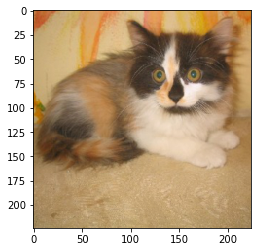

In [65]:
x = 600
im = inv_normalize(test_data[x][0])
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

In [66]:
test_data[x][0].shape

torch.Size([3, 224, 224])

In [67]:
# CNN Model Prediction:

CNNmodel.eval()
with torch.no_grad():
    new_pred = CNNmodel(test_data[x][0].view(1,3,224,224)).argmax()
print(f'Predicted value: {new_pred.item()} {class_names[new_pred.item()]}')

Predicted value: 0 CAT


In [68]:
# resnet18 model Prediction:

resnet18.eval()
with torch.no_grad():
    new_pred = resnet18(test_data[x][0].view(1,3,224,224)).argmax()
print(f'Predicted value: {new_pred.item()} {class_names[new_pred.item()]}')

Predicted value: 0 CAT


## Load the pretrained vgg11 model 

In [69]:
vgg11 = models.vgg11(pretrained = True)
vgg11

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (16): Conv2d(512, 512, kern

In [70]:
for params in vgg11.parameters():
    print(params.numel())

1728
64
73728
128
294912
256
589824
256
1179648
512
2359296
512
2359296
512
2359296
512
102760448
4096
16777216
4096
4096000
1000


In [71]:
for params in vgg11.classifier.parameters():
    print(params.numel())

102760448
4096
16777216
4096
4096000
1000


## Freeze feature parameters

In [72]:
for param in vgg11.parameters():
    param.requires_grad = False

## Modify the classifier

In [73]:
torch.manual_seed(42)
vgg11.classifier = nn.Sequential(nn.Linear(25088, 1024),
                                 nn.ReLU(),
                                 nn.Dropout(0.5),
                                 nn.Linear(1024,2),
                                 nn.LogSoftmax(dim=1))
vgg11

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (16): Conv2d(512, 512, kern

## check the number of parameters

In [74]:
for params in vgg11.classifier.parameters():
    print(params.numel())

25690112
1024
2048
2


## Define loss function & optimizer

In [77]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vgg11.classifier.parameters(), lr=0.001)

## Train the model

In [78]:
import time
start_time = time.time()

epochs = 1

max_trn_batch = 500
max_tst_batch = 200

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        if b == max_trn_batch:
            break
        b+=1
        
        # Apply the model
        y_pred = vgg11(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        if b%50 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/8000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')

    train_losses.append(loss)
    train_correct.append(trn_corr)

    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            if b == max_tst_batch:
                break

            # Apply the model
            y_val = vgg11(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:  0  batch:   50 [   500/8000]  loss: 0.00000000  accuracy:  80.800%
epoch:  0  batch:  100 [  1000/8000]  loss: 0.00000000  accuracy:  86.600%
epoch:  0  batch:  150 [  1500/8000]  loss: 430.70645142  accuracy:  88.200%


KeyboardInterrupt: 

## Check the accuracy on test

In [ ]:
print(test_correct)
print(f'Test accuracy: {test_correct[-1].item()*100/3000:.3f}%')

## Run a new image through the model

In [ ]:
x = 2019
im = inv_normalize(test_data[x][0])
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

### CNN Model Prediction:


In [ ]:
CNNmodel.eval()
with torch.no_grad():
    new_pred = CNNmodel(test_data[x][0].view(1,3,224,224)).argmax()
print(f'Predicted value: {new_pred.item()} {class_names[new_pred.item()]}')

### vgg11 model Prediction:

In [ ]:
vgg11.eval()
with torch.no_grad():
    new_pred = vgg11(test_data[x][0].view(1,3,224,224)).argmax()
print(f'Predicted value: {new_pred.item()} {class_names[new_pred.item()]}')

## Load the Pretrained model

In [79]:
AlexNetmodel = models.alexnet(pretrained=True)
AlexNetmodel

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p

<div class="alert alert-info">This model uses <a href='https://pytorch.org/docs/master/nn.html#torch.nn.AdaptiveAvgPool2d'><tt><strong>torch.nn.AdaptiveAvgPool2d(<em>output_size</em>)</strong></tt></a> to convert the large matrix coming out of the convolutional layers to a (6x6)x256 matrix being fed into the fully connected layers.</div>

## Freeze feature parameters
We want to freeze the pre-trained weights & biases. We set <tt>.requires_grad</tt> to False so we don't backprop through them.

In [80]:
for param in AlexNetmodel.parameters():
    param.requires_grad = False

## Modify the classifier
Next we need to modify the fully connected layers to produce a binary output. The section is labeled "classifier" in the AlexNet model.<br>
Note that when we assign new layers, their parameters default to <tt>.requires_grad=True</tt>.

In [81]:
torch.manual_seed(42)
AlexNetmodel.classifier = nn.Sequential(nn.Linear(9216, 1024),
                                 nn.ReLU(),
                                 nn.Dropout(0.4),
                                 nn.Linear(1024, 2),
                                 nn.LogSoftmax(dim=1))
AlexNetmodel

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4)
    (3): Linear(in_featur

In [82]:
# These are the TRAINABLE parameters:
count_parameters(AlexNetmodel)

9437184 
1024    
2048    
2       
________
9440258 


## Define loss function & optimizer
We only want to optimize the classifier parameters, as the feature parameters are frozen.

In [83]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(AlexNetmodel.classifier.parameters(), lr=0.001)

## Train the model
Remember, we're only training the fully connected layers. The convolutional layers have fixed weights and biases. For this reason, we only need to run one epoch.

In [84]:
import time
start_time = time.time()

epochs = 1

max_trn_batch = 800
max_tst_batch = 300

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        if b == max_trn_batch:
            break
        b+=1
        
        # Apply the model
        y_pred = AlexNetmodel(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        if b%200 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/8000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')

    train_losses.append(loss)
    train_correct.append(trn_corr)

    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            if b == max_tst_batch:
                break

            # Apply the model
            y_val = AlexNetmodel(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:  0  batch:  200 [  2000/8000]  loss: 0.03124138  accuracy:  89.050%
epoch:  0  batch:  400 [  4000/8000]  loss: 0.01322311  accuracy:  91.250%
epoch:  0  batch:  600 [  6000/8000]  loss: 0.04146026  accuracy:  92.017%
epoch:  0  batch:  800 [  8000/8000]  loss: 0.03943853  accuracy:  92.412%

Duration: 704 seconds


In [23]:
print(test_correct)
print(f'Test accuracy: {test_correct[-1].item()*100/3000:.3f}%')

[tensor(2810)]
Test accuracy: 93.667%


## Run a new image through the model
We can also pass a single image through the model to obtain a prediction.<br>
Pick a number from 0 to 6250, assign it to "x", and we'll use that value to select an image from the Cats and Dogs test set.

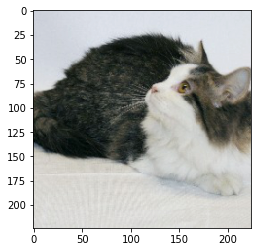

In [31]:
x = 2019
im = inv_normalize(test_data[x][0])
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

In [32]:
test_data[x][0].shape

torch.Size([3, 224, 224])

In [35]:
# CNN Model Prediction:

CNNmodel.eval()
with torch.no_grad():
    new_pred = CNNmodel(test_data[x][0].view(1,3,224,224)).argmax()
print(f'Predicted value: {new_pred.item()} {class_names[new_pred.item()]}')

Predicted value: 1 DOG


In [36]:
# AlexNet Model Prediction:

AlexNetmodel.eval()
with torch.no_grad():
    new_pred = AlexNetmodel(test_data[x][0].view(1,3,224,224)).argmax()
print(f'Predicted value: {new_pred.item()} {class_names[new_pred.item()]}')

Predicted value: 0 CAT
